In [557]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
Bernoulli = tf.contrib.distributions.Bernoulli\

### Utilitiy functions

In [558]:
def plot_banded_error(errs, label, ax=None):
    ax = ax or plt
    m = np.mean(errs, axis=0)
    s = np.std(errs, axis=0)
    line, = ax.plot(np.arange(1, len(m)+1), m, '.-', label=label)
  #  ax.fill_between(np.arange(1, len(m)+1), m-s, m+s, color=line.get_color(), alpha=0.075)

def fatlegend(ax, *a, **kw):
    leg = ax.legend(*a, **kw)
    for l in leg.legendHandles:
        l.set_linewidth(l.get_linewidth()*2.0)
    return leg

def add_layer(inputs, wn, bn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn, [in_dim, out_dim])
            b = tf.get_variable(bn, [1, out_dim])
    if af is None:
        return tf.matmul(inputs, w) + b
    return af(tf.matmul(inputs, w) + b)

def get_weights(wn, bn, in_dim, out_dim):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        w = tf.get_variable(wn, [in_dim, out_dim])
        b = tf.get_variable(bn, [1, out_dim])
    return [w,b]

def log_prob(p, s):
    return tf.log(tf.clip_by_value(s*p+(1.0-s)*(1.0-p), eps, 1-eps))

### Parameters

In [559]:
batch_size = 10
ns = 10
lr = 1e-3
eps = 1e-7
alpha = 0.9
steps = 50000

### Sigmoid belief networks

In [560]:
x = tf.placeholder(tf.float32, [None, 392])
h = tf.tile(add_layer(x, "wxh", "bxh", 392, 200, tf.nn.sigmoid), [ns,1])
sh = tf.stop_gradient(Bernoulli(probs=h, dtype=tf.float32).sample())
y = add_layer(sh, "why", "bhy", 200, 392, tf.nn.sigmoid)
y_expect = tf.reduce_mean(tf.reshape(y, [ns, batch_size, 392]), 0)
y_ = tf.placeholder(tf.float32, [None, 392])

nll = tf.reduce_mean(tf.reduce_sum(-log_prob(y_expect, y_), 1))
loss = tf.reduce_sum(-log_prob(y, tf.tile(y_,[ns,1])), 1, keep_dims=True)

saver = tf.train.Saver()

### Gradient estimators

In [561]:
bsln = tf.placeholder(tf.float32)
bslnv = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(lr)

def gd_est(md, linear=True):
    func = {
        0: lambda: [tf.stop_gradient(loss)] + [tf.constant([0.])]*4 + [None],
        1: muProp,
        2: DARN,
        3: baseline,
        4: NVIL
    }
    f, g, mg, m, v, tr = func.get(md)()
    
    if linear:
        dy = opt.compute_gradients(nll, get_weights("why", "bhy", 200, 392))       
        dh = opt.compute_gradients(tf.reduce_mean((f-g)*log_prob(h,sh)+mg, 0), 
                                   get_weights("wxh", "bxh", 392, 200))
        est = dy + dh if tr is None else dy+dh+tr
    else:
        est = opt.compute_gradients(nll+tf.reduce_mean((f/g)*mg, 0), [get_weights("wxh", "bxh", 392, 200),
                                                                      get_weights("why", "bhy", 200, 392)])

    train_step = opt.apply_gradients(est)
    return train_step, y_expect, nll, m, v

def muProp():
    ch = add_layer(h, "why", "bhy", 200, 392, tf.nn.sigmoid)
    loss_ch = tf.reduce_sum(-log_prob(ch, tf.tile(y_,[ns,1])), 1, keep_dims=True)
    dh = tf.gradients(loss_ch, h)[0]
    
    coef = cv_coef(loss_ch, dh)
    
    g = tf.stop_gradient(coef * (loss_ch+tf.reduce_sum(dh*(sh-h),1,keep_dims=True)))
    mg = tf.stop_gradient(coef * dh) * h
    return tf.stop_gradient(loss), g, mg, tf.constant(0.), tf.constant(0.), None
        
def DARN():
    dh = tf.gradients(loss, sh)[0]
    g = tf.stop_gradient(loss + dh*(0.5-sh))
    return tf.stop_gradient(loss), g, tf.constant(0.), tf.constant(0.), tf.constant(0.), None

def baseline():
    b = alpha*bsln + (1.0-alpha)*tf.reduce_mean(loss)
    g = tf.stop_gradient(b) * p
    f = tf.stop_gradient(loss) * p
    return f, g, tf.constant(0.), b, tf.constant(0.), None

def NVIL():
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    b = alpha*bsln + tf.reduce_mean((1.0-alpha)*(loss-cy))
    vv = tf.reduce_mean(tf.square(loss-cy-tf.reduce_mean(loss-cy)))/tf.maximum(1.0, (ns-1))
    v = alpha*bslnv + (1.0-alpha)*vv
    g = tf.stop_gradient((cy+b)/tf.maximum(1.0,tf.sqrt(v))) * p
    f = tf.stop_gradient(loss/tf.maximum(1.0,tf.sqrt(v))) * p
    tr = opt.compute_gradients(tf.reduce_mean(tf.square(tf.stop_gradient(loss-b)-cy)), [get_weights("wh", "bh", 392, 100),
                                                                                        get_weights("wy", "by", 100, 1)])
    return f, g, None, tr, b, v

def ST_():
    train_step = tf.train.AdamOptimizer(lr).minimize(nll)
    return train_step, nll, tf.constant(0.), tf.constant(0.)

In [562]:
def cv_coef(loss_ch, dh):
    ss = tf.stop_gradient(Bernoulli(probs=h, dtype=tf.float32).sample())
    sy = add_layer(ss, "why", "bhy", 200, 392, tf.nn.sigmoid)
    sloss = tf.reduce_sum(-log_prob(sy, tf.tile(y_,[ns,1])), 1, keep_dims=True)

    f = tf.stop_gradient(sloss) * log_prob(h, ss)    
    g = tf.stop_gradient(loss_ch+tf.reduce_sum(dh*(ss-h),1,keep_dims=True)) * log_prob(h, ss)
    df, dg = [tf.gradients(tf.reduce_mean(z, 0), get_weights("wxh", "bxh", 392, 200)) for z in [f,h]]
    mf, mg = [tf.concat([z[0], z[1]], 0) for z in [df, dg]]
    _f, _g = [tf.reshape(z, [ns, batch_size, 200]) for z in [f,g]]
    for i in range(ns):
        _df, _dg = [tf.gradients(tf.reduce_mean(z[i],0), get_weights("wxh", "bxh", 392, 200)) for z in [_f, _g]]
        _df_, _dg_ = [tf.concat([z[0], z[1]], 0) for z in [_df, _dg]]
        if i==0:
            vg = tf.square(_dg_ - mg)
            cov = (_df_ - mf)*(_dg_ - mg)
        else:
            vg += tf.square(_dg_ - mg)
            cov += (_df_ - mf)*(_dg_ - mg)
    return tf.reduce_sum(cov)/tf.reduce_sum(vg)

In [563]:
def train(train_op):
    with tf.Session() as sess:
        data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
        data.images[data.images>0.5] = 1.0
        data.images[data.images<=0.5] = 0.0
        bl = 0.
        vr = 0.
        ll = np.empty((1000, steps/1000))
        sess.run(tf.global_variables_initializer())

        for i in range(steps):
            batch_ = data.next_batch(batch_size, shuffle=False)[0]
            batch_xs = batch_[:,0:392]
            batch_ys = batch_[:,392:784]

            res = sess.run(train_op, {x: batch_xs, y_: batch_ys, bsln: bl, bslnv: vr})
            bl = res[-2]
            vr = res[-1]   
            ll[i%1000, i/1000] = res[-3]
            if (i+1)%1000==0:
                print (i+1)/1000, np.mean(ll[:, i/1000], 0),
#        save_path = saver.save(sess, "model/model.ckpt")
    return ll, batch_xs, batch_ys, res[1]

In [564]:
#train_op = ST_()
train_op = gd_est(1, True)
result = train(train_op)
mp_10_10_beta = result[0]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
1 225.520951164 2 140.982672997 3 123.620494942 4 113.204749779 5 105.90709021 6 100.450969437 7 96.4093109436 8 93.1427414474 9 90.5007136993 10 88.4425987015 11 86.6904766693 12 85.301260498 13 84.0200223885 14 83.0434430428 15 82.1479459572 16 81.4422181473 17 80.7063895798 18 80.1479609032 19 79.6052191658 20 79.1300749626 21 78.6250201035 22 78.1962802925 23 77.8665493507 24 77.54879813 25 77.2202657433 26 76.8546724815 27 76.5510178642 28 76.2604244194 29 76.0156341133 30 75.7677364769 31 75.5267977638 32 75.2476134796 33 74.9813723183 34 74.8431520157 35 74.6112151413 36 74.423853096 37 74.2347917557 38 74.0224766197 39 73.8537947578 40 73.7195788956 41 73.5364619446 42 73.3967292709 43 73.2512439842 44 73.1107393036 45 72.9522594261 46 72.8057930374 47 72.643789032 48 72.5171488533 49 72

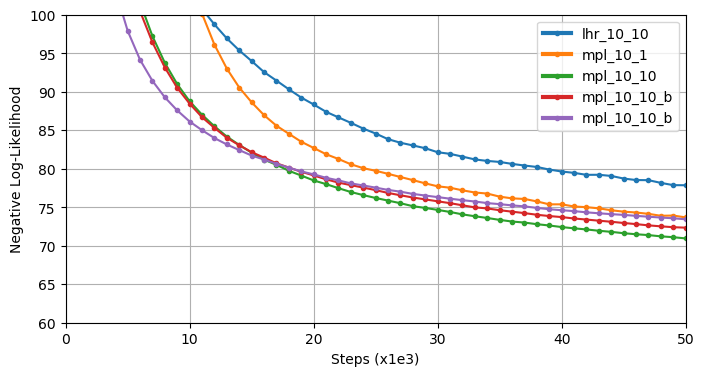

In [565]:
plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(8,4))
plt.xlim(0, 50)
plt.ylim(60, 100)

plot_banded_error(lhr_10_10, "lhr_10_10")
plot_banded_error(mpl_10_1, "mpl_10_1", ax)
plot_banded_error(mpl_10_10, "mpl_10_10", ax)
plot_banded_error(mp_10_10_beta, "mpl_10_10_b", ax)
plot_banded_error(mp_10_10_beta_2, "mpl_10_10_b", ax)



#plot_banded_error(mpr_10_1, "mpr_10_1", ax)
#plot_banded_error(ST_10_1, "ST_10_1", ax)

fatlegend(ax)
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
ax.grid(True)
plt.show()
#fig.savefig('foo.png')

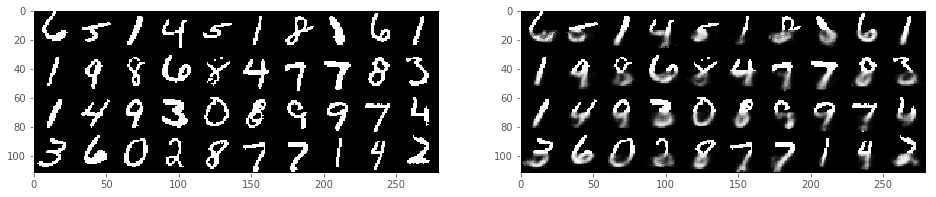

In [319]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
up = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[1]]], 1)
dw = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[2]]], 1)
p1 = np.concatenate(np.split(np.concatenate([up,dw], 0), batch_size/10, 1), 0)
dwy = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[3]]], 1)
p2 = np.concatenate(np.split(np.concatenate([up,dwy], 0), batch_size/10, 1), 0)
ax[0].imshow(p1, cmap=plt.cm.gray, interpolation='none')
ax[1].imshow(p2, cmap=plt.cm.gray, interpolation='none')
ax[0].grid(False)
ax[1].grid(False)
plt.show()